In [1]:
%matplotlib inline

In [142]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('Set2')

In [143]:
import glob
import os

def get_latest_file_glob(pat):    
    list_of_files = glob.glob(pat) # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

In [144]:
latest_niv = get_latest_file_glob('datagov_archive/corona_tested_individuals_ver_*.csv.gz')
niv = pd.read_csv(latest_niv, 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

test_date  cough  fever  sore_throat  shortness_of_breath  head_ache  \
0 2020-12-06      0      0            0                    0          0   
1 2020-12-06      0      0            0                    0          0   
2 2020-12-06      0      0            0                    0          0   
3 2020-12-06      0      0            0                    0          0   
4 2020-12-06      0      0            0                    0          0   

  corona_result age_60_and_above gender         test_indication  
0         שלילי               No   נקבה                   Other  
1         שלילי              Yes    זכר                   Other  
2         שלילי               No    זכר                   Other  
3         שלילי               No    זכר                   Other  
4         שלילי               No   נקבה  Contact with confirmed

In [145]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [146]:
latest_bdi = get_latest_file_glob('datagov_archive/corona_lab_tests_ver_*.csv.gz')
bdi = pd.read_csv(latest_bdi, encoding='utf-8', parse_dates=[0,1])

In [147]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [148]:
bdi.head()

test_date result_date corona_result  lab_id  test_for_corona_diagnosis  \
0 2020-08-09  2020-08-09         חיובי       2                          1   
1 2020-08-09  2020-08-09         שלילי       2                          1   
2 2020-08-10  2020-08-10         שלילי       2                          1   
3 2020-03-11  2020-03-11         חיובי       1                          1   
4 2020-03-11  2020-03-11         שלילי       3                          1   

  is_first_Test orig_test_date  
0            No            NaT  
1           Yes            NaT  
2           Yes            NaT  
3           Yes     2020-03-11  
4           Yes     2020-03-11

In [149]:
bdi.shape

(6353667, 7)

In [150]:
niv.corona_result.value_counts()

שלילי    2888414
חיובי     233560
אחר        55157
Name: corona_result, dtype: int64

In [151]:
bdi.corona_result.value_counts()

שלילי                 5764234
חיובי                  416984
חיובי גבולי             60199
לא בוצע/פסול 999        58475
לא בוצע – איגום         27754
שלילי סופיה             21981
חיובי באיגום             1622
בעבודה                   1126
חיובי גבולי באיגום        895
לא ודאי ישן               397
Name: corona_result, dtype: int64

In [152]:
niv.corona_result.value_counts()

שלילי    2888414
חיובי     233560
אחר        55157
Name: corona_result, dtype: int64

In [153]:
niv.test_indication.value_counts()

Other                     2960111
Contact with confirmed     193484
Abroad                      23536
Name: test_indication, dtype: int64

In [154]:
niv.age_60_and_above.value_counts()

No     2254860
Yes     349512
Name: age_60_and_above, dtype: int64

In [155]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [156]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
    'שלילי סופיה': 'negative',
    'חיובי גבולי': 'boderline',
    'לא בוצע – איגום': 'not_done',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [157]:
bdi_result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'חיובי גבולי': 'borderline',
    'לא בוצע/פסול 999': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
    'לא ודאי ישן': 'uncertain',
    'אחר': 'other',
    'חיובי באיגום': 'positive_igum',
    'חיובי גבולי באיגום': 'positive_igum',
}
bdi['corona_result'] = bdi.corona_result.map(bdi_result_map)

In [158]:
bdi.corona_result.value_counts()

negative         5764234
positive          416984
borderline         60199
not_done           58475
positive_igum       2517
in_progress         1126
uncertain            397
Name: corona_result, dtype: int64

In [159]:
rec = pd.read_csv(get_latest_file_glob('datagov_archive/corona_recovered_ver_*.csv.gz'), encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

days_between_pos_and_neg total_tests_count age_group gender  \
0                        19                 9     40-49    זכר   
1                        22                 9     30-39    זכר   
2                        26                 9     30-39    זכר   
3                        28                 9     30-39   נקבה   
4                        23                 9     20-29   נקבה   

          test_indication  
0                  Abroad  
1  Contact with confirmed  
2  Contact with confirmed  
3                  Abroad  
4  Contact with confirmed

In [160]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

total_tests_count   size  min  max       mean  median  test_sum
0                  2      6    6   17  12.833333      13        12
1                  3  11061    2  112  16.665582      17     33183
2                  4   5081    2  114  21.462114      21     20324
3                  5   3127    2  106  24.647905      25     15635
4                  6   1786    6   96  27.668533      27     10716
5                  7   1063    8  108  30.398871      30      7441
6                  8    597    3  103  33.475712      33      4776
7                  9    357    3   78  35.700280      35      3213
8                 10    573    5  106  41.130890      41      5730

In [161]:
(rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('10+', '11').replace('11+', '12')
                                .astype(int)))
 .total_tests_count.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()

index  total_tests_count
0    size       23651.000000
1     min           2.000000
2     max          12.000000
3    mean           4.320156
4  median           4.000000

In [162]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(10).index]


days_between_pos_and_neg total_tests_count age_group gender  \
9432                        114                 4       60+    זכר   
12342                       112                 3     30-39    זכר   
9304                        111                 4     20-29    זכר   
1600                        108                 7     40-49   נקבה   
6311                        106                 5     30-39    זכר   
23175                       106               10+      0-19   נקבה   
9696                        105                 4     30-39   נקבה   
456                         103                 8     50-59   נקבה   
20936                       103                 3      0-19    זכר   
23273                       100               10+       60+    זכר   

              test_indication  
9432                    Other  
12342  Contact with confirmed  
9304                    Other  
1600   Contact with confirmed  
6311   Contact with confirmed  
23175  Contact with confirmed  
9696                    Other  
456    Contact with confirmed  
20936                  Abroad  
23273  Contact with confirmed

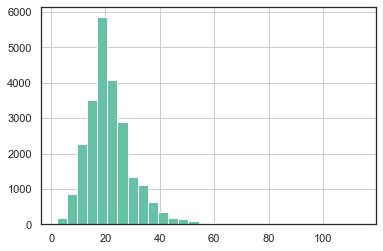

In [163]:
rec.days_between_pos_and_neg.hist(bins=30)

In [164]:
iso = pd.read_csv(get_latest_file_glob('datagov_archive/corona_isolation_per_day_ver_*.csv.gz'),
                  encoding='utf-8-sig', low_memory=False)
iso.head()

date  isolated_today_contact_with_confirmed  isolated_today_abroad  \
0  2020-12-05                                  56130                  26534   
1  2020-12-04                                  54439                  26598   
2  2020-12-03                                  53823                  27561   
3  2020-12-02                                  51132                  26993   
4  2020-12-01                                  48543                  27267   

  new_contact_with_confirmed new_from_abroad  
0                       5037            1149  
1                       5932            1304  
2                       7341            2136  
3                       6838            1830  
4                       6691            1916

In [165]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [166]:
niv.age_60_and_above.value_counts()

No     2254860
Yes     349512
Name: age_60_and_above, dtype: int64

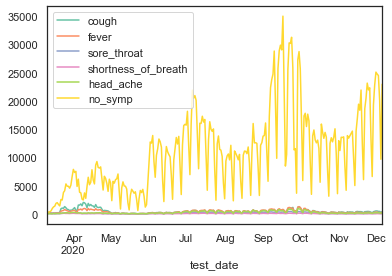

In [167]:
niv.groupby('test_date')[symptom_cols].sum().plot()

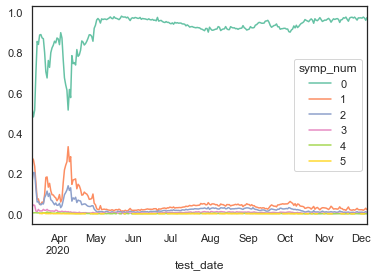

In [168]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

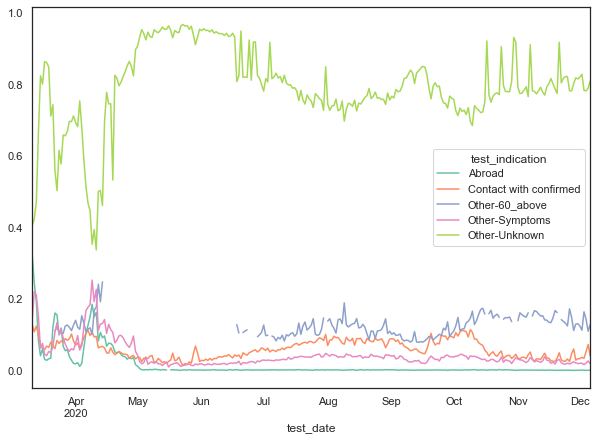

In [169]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

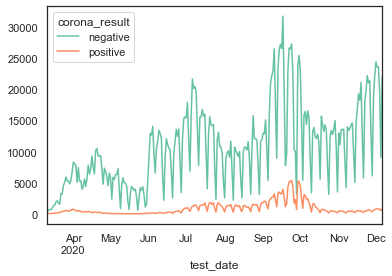

In [170]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [171]:
bdi.dtypes

test_date                    datetime64[ns]
result_date                  datetime64[ns]
corona_result                        object
lab_id                                int64
test_for_corona_diagnosis             int64
is_first_Test                        object
orig_test_date               datetime64[ns]
dtype: object

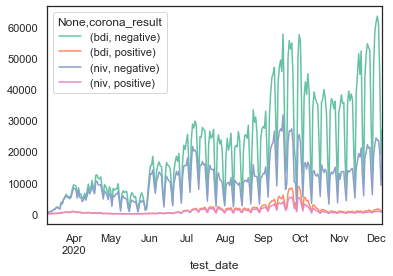

In [172]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

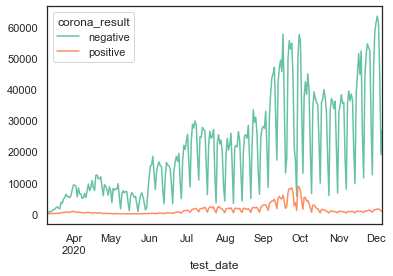

In [173]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [174]:
pone = bdi[(bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)][['test_date', 'corona_result']].fillna('Other').groupby(['test_date', 'corona_result'], sort=False).size().unstack()
pone[pone.positive>20]

corona_result  positive  negative  uncertain  in_progress  not_done  \
test_date                                                             
2020-08-09       1613.0   21219.0        NaN          1.0      77.0   
2020-08-10       1859.0   21918.0        NaN          1.0     112.0   
2020-03-12         31.0     615.0        NaN          2.0       1.0   
2020-03-25        502.0    5304.0       49.0         21.0      42.0   
2020-03-13         33.0     721.0        NaN          NaN       NaN   
...                 ...       ...        ...          ...       ...   
2020-12-03       1531.0   61080.0        NaN          7.0     796.0   
2020-11-28        553.0   12541.0        NaN          3.0      43.0   
2020-12-05        994.0   18960.0        NaN          5.0      99.0   
2020-12-06        743.0   26977.0        NaN          2.0     206.0   
2020-12-04       1386.0   43806.0        NaN          3.0     228.0   

corona_result  borderline   Other  positive_igum  
test_date                                         
2020-08-09           94.0     NaN            NaN  
2020-08-10          162.0     NaN            NaN  
2020-03-12            NaN     NaN            NaN  
2020-03-25            NaN     NaN            NaN  
2020-03-13            NaN     NaN            NaN  
...                   ...     ...            ...  
2020-12-03          229.0  2512.0            8.0  
2020-11-28           65.0   987.0            NaN  
2020-12-05           86.0  1014.0            NaN  
2020-12-06           55.0  2021.0            NaN  
2020-12-04          181.0  1171.0            NaN  

[260 rows x 8 columns]

In [175]:
pone.tail(5)

corona_result  positive  negative  uncertain  in_progress  not_done  \
test_date                                                             
2020-12-03       1531.0   61080.0        NaN          7.0     796.0   
2020-11-28        553.0   12541.0        NaN          3.0      43.0   
2020-12-05        994.0   18960.0        NaN          5.0      99.0   
2020-12-06        743.0   26977.0        NaN          2.0     206.0   
2020-12-04       1386.0   43806.0        NaN          3.0     228.0   

corona_result  borderline   Other  positive_igum  
test_date                                         
2020-12-03          229.0  2512.0            8.0  
2020-11-28           65.0   987.0            NaN  
2020-12-05           86.0  1014.0            NaN  
2020-12-06           55.0  2021.0            NaN  
2020-12-04          181.0  1171.0            NaN

In [179]:
niv.shape

(3177131, 12)

In [180]:
bdi[bdi.is_first_Test=='Yes'].shape

(2965310, 7)

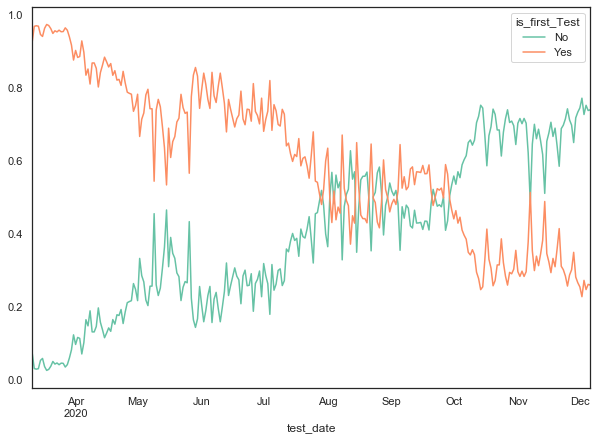

In [36]:
ti = bdi[(bdi.test_date>'2020') 
         & (bdi.test_date<'2021') 
         & (bdi.test_for_corona_diagnosis)].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

In [37]:
(ti.div(ti.sum(axis=1), axis=0))

is_first_Test        No       Yes
test_date                        
2020-03-11     0.073446  0.926554
2020-03-12     0.030817  0.969183
2020-03-13     0.029178  0.970822
2020-03-14     0.030464  0.969536
2020-03-15     0.053219  0.946781
...                 ...       ...
2020-12-02     0.772165  0.227835
2020-12-03     0.727476  0.272524
2020-12-04     0.752667  0.247333
2020-12-05     0.738350  0.261650
2020-12-06     0.740235  0.259765

[271 rows x 2 columns]

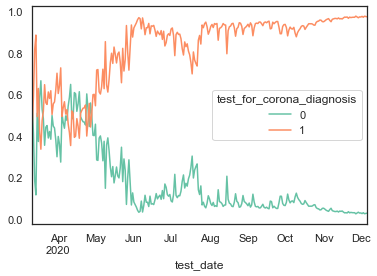

In [38]:
ti = bdi[(bdi.is_first_Test=='No')].groupby(['test_date', 'test_for_corona_diagnosis']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

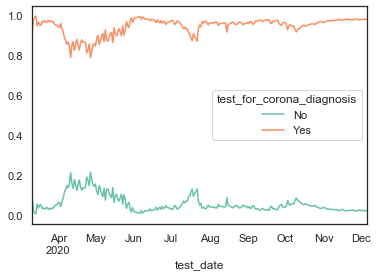

In [39]:
ti = bdi.groupby(['test_date', 'test_for_corona_diagnosis']).size().unstack()
ti = ti.rename(columns={0: 'No', 1: 'Yes'})
(ti.div(ti.sum(axis=1), axis=0)).plot()

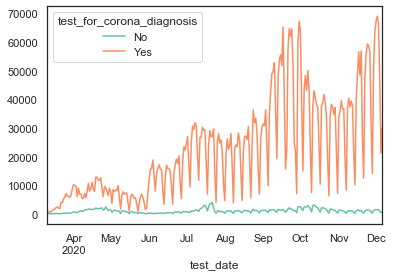

In [40]:
ti.plot()

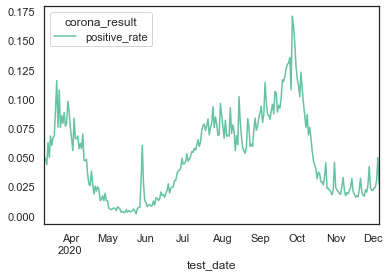

In [41]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain))[['positive_rate']]
 .plot())

In [42]:
import altair as alt

In [43]:
ti.tail()

test_for_corona_diagnosis    No    Yes
test_date                             
2020-12-02                 1393  69050
2020-12-03                 1473  66163
2020-12-04                  893  46775
2020-12-05                  418  21158
2020-12-06                  631  30004

In [44]:
ti.Yes.sum() + ti.No.sum()

6353654

In [45]:
alt.Chart(ti.reset_index().assign(total=lambda x: (x.Yes+x.No))).mark_line().encode(
    x='test_date',
    y='total',
    tooltip=['test_date', 'total']
).interactive()

alt.Chart(...)

In [46]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [47]:
alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive']
).interactive()

alt.Chart(...)

In [48]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')
          ]
 .groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative+x.borderline+x.uncertain)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [49]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'חולים בינוני': 'medium',
            'מונשמים': 'resp'}

In [50]:
get_latest_file_glob('datagov_archive/corona_hospitalization_ver_*.xlsx.gz')

'datagov_archive\\corona_hospitalization_ver_00158_20201209120320.xlsx.gz'

In [51]:
import gzip
hos = (pd.read_excel(gzip.open(get_latest_file_glob('datagov_archive/corona_hospitalization_ver_*.xlsx.gz')))
       .fillna('<15')
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.replace('<15', '15').astype(int))
      .assign(medium = lambda x: x.medium.fillna('<15').replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.tail()

date  מאושפזים  אחוז נשים מאושפזות  גיל ממוצע מאושפזים  \
266 2020-12-02       574                44.4                  63   
267 2020-12-03       579                44.7                  64   
268 2020-12-04       601                44.9                  63   
269 2020-12-05       592                44.4                  64   
270 2020-12-06       624                44.4                  64   

     סטיית תקן גיל מאושפזים  resp  אחוז נשים מונשמות  גיל ממוצע מונשמים  \
266                    19.1    88               39.8                 69   
267                    19.0    84               38.1                 68   
268                    19.2    93               37.6                 67   
269                    18.7    85               38.8                 68   
270                    18.8    85               41.2                 68   

     סטיית תקן גיל מונשמים  חולים קל  ...  סטיית תקן גיל חולים קל  medium  \
266                   12.8       182  ...                    24.1     108   
267                   11.5       173  ...                    25.0     106   
268                   12.4       184  ...                    25.0      99   
269                   12.2       178  ...                    23.9      92   
270                   13.2       195  ...                    23.9      89   

     אחוז נשים חולות בינוני  גיל ממוצע חולים בינוני  \
266                    48.1                      66   
267                    53.8                      64   
268                    52.5                      65   
269                      50                      66   
270                    51.7                      65   

    סטיית תקן גיל חולים בינוני critical אחוז נשים חולות קשה  \
266                       17.7      284                38.7   
267                       17.4      300                36.3   
268                       16.3      318                36.8   
269                       16.1      322                38.8   
270                       16.4      340                38.2   

     גיל ממוצע חולים קשה  סטיית תקן גיל חולים קשה  חולים קשה מצטבר  
266                   67                     13.8             7704  
267                   67                     13.9             7747  
268                   67                     14.2             7784  
269                   68                     14.5             7814  
270                   67                     15.0             7849  

[5 rows x 22 columns]

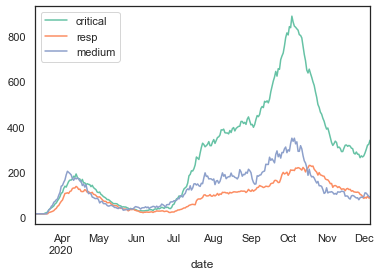

In [52]:
(hos[['date', 'critical', 'resp', 'medium']].set_index('date').plot())

In [53]:
hos_and_rate = hos[['date', 'critical', 'resp', 'medium']].rename(columns={'date': 'test_date'}).merge(pr, on='test_date')
hos_and_rate.head()


test_date  critical  resp  medium  borderline  in_progress  negative  \
0 2020-03-11        15    15      15         0.0         18.0     324.0   
1 2020-03-12        15    15      15         0.0          2.0     616.0   
2 2020-03-13        15    15      15         0.0          0.0     721.0   
3 2020-03-14        15    15      15         0.0          3.0     704.0   
4 2020-03-15        15    15      15         0.0         93.0    1025.0   

   not_done  positive  positive_igum  uncertain  positive_rate  
0       0.0      45.0            0.0        1.0       0.121622  
1       1.0      45.0            0.0        0.0       0.068079  
2       0.0      38.0            0.0        0.0       0.050066  
3       1.0      50.0            0.0        0.0       0.066313  
4       9.0     103.0            0.0        0.0       0.091312

In [54]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [55]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive = lambda x: x.positive.ewm(span=7).mean())
               .assign(positive_label ='positive')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positives (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

No handles with labels found to put in legend.


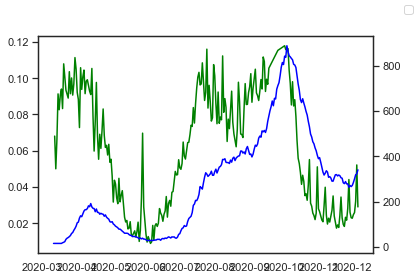

In [56]:
sns.lineplot(data=hos_and_rate[hos_and_rate.positive_rate<0.12].set_index('test_date').positive_rate, color="g")
ax2 = plt.twinx()
sns.lineplot(data=hos_and_rate.set_index('test_date').critical, color="b", ax=ax2)
ax2.figure.legend()


In [57]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical+med')
               .assign(crit_med = lambda x: (x.critical+x.medium).ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_med',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [58]:
hos_and_rate['pos_pct_change'] = hos_and_rate.positive_rate.pct_change()
hos_and_rate['crit_pct_change'] = hos_and_rate.critical.pct_change()


In [59]:
c1 = alt.Chart(hos_and_rate
               .assign(pos_pct_change = lambda x: x.pos_pct_change.ewm(span=7).mean())
              ).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='pos_pct_change',
    tooltip=['test_date', 'positive_rate'],
)
c2 = alt.Chart(hos_and_rate
               .assign(crit_pct_change = lambda x: x.crit_pct_change.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_pct_change',
    tooltip=['test_date', 'critical'],
)


alt.layer(c1, c2).properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

## Positive rate by Lab

In [60]:
polab = bdi[(bdi.test_date<'2021') & (bdi.test_for_corona_diagnosis)][['test_date', 'lab_id', 'corona_result']].fillna('Other').groupby(['test_date', 'lab_id', 'corona_result']).size().unstack().fillna(0)
polab['total_tests'] = polab.sum(axis=1)
polab['positive_rate'] = polab.positive/(polab.positive+polab.negative+polab.borderline+polab.uncertain)

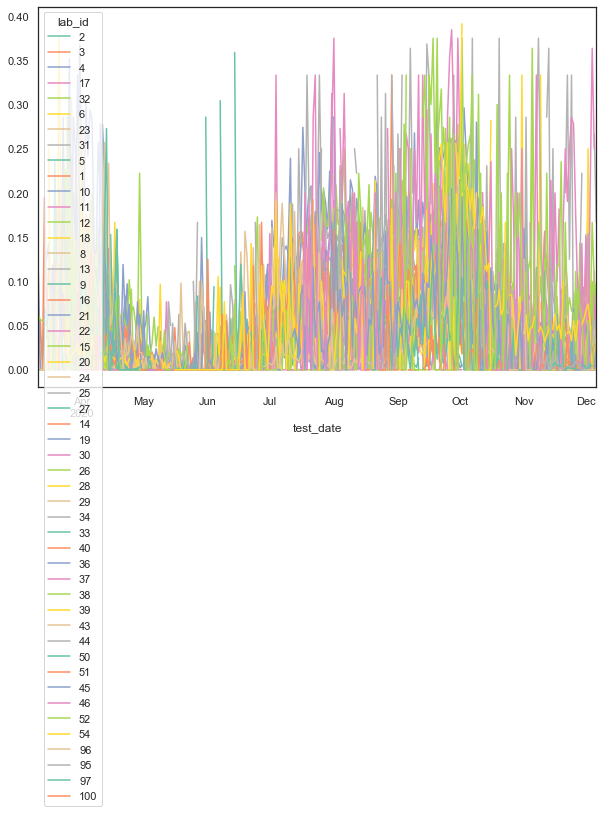

In [61]:
polab[polab.positive_rate<0.4].positive_rate.unstack().plot(figsize=(10,7))

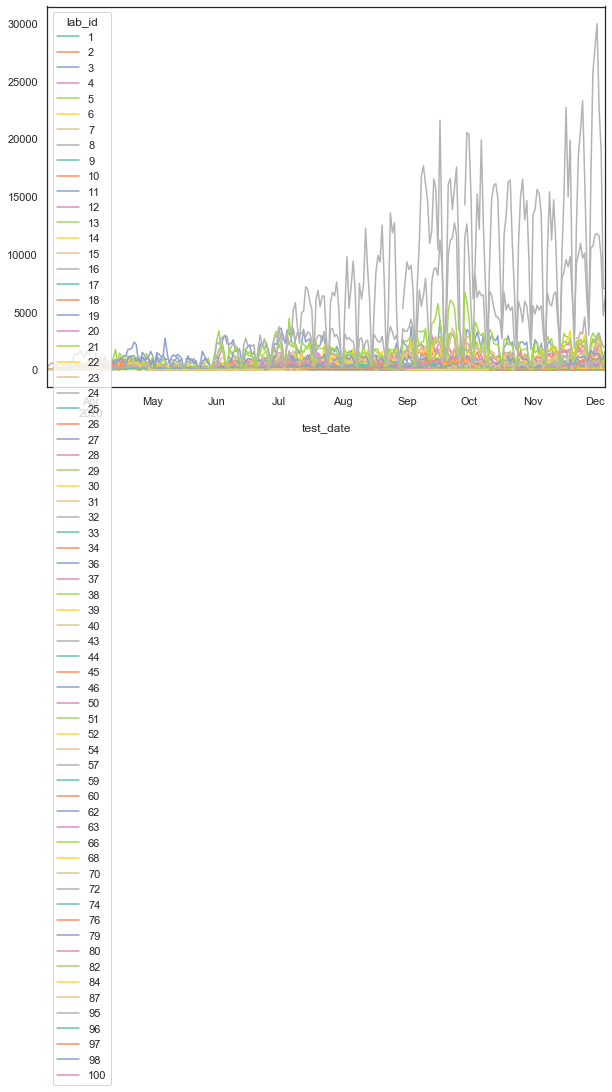

In [62]:
polab.total_tests.unstack().plot(figsize=(10,7))

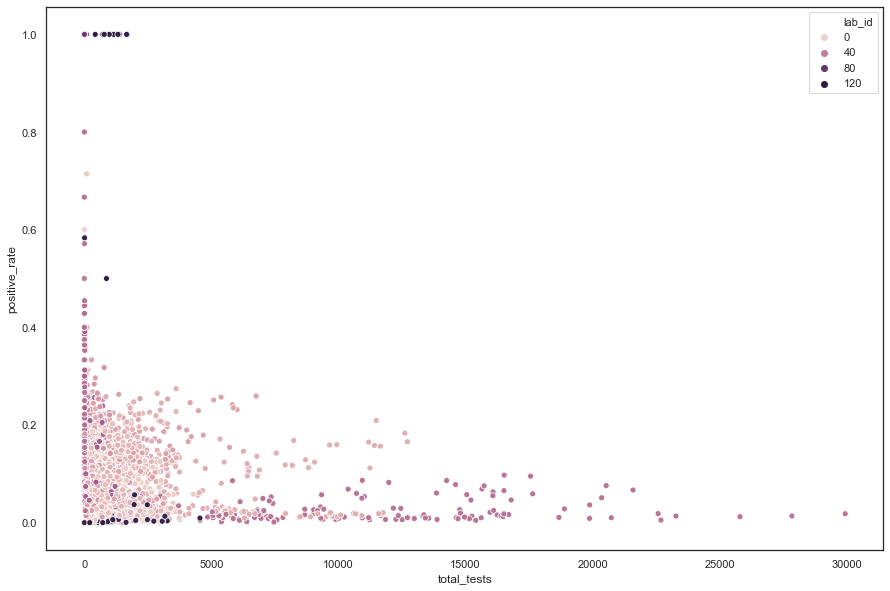

In [63]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(data=polab.reset_index(), x='total_tests', y='positive_rate', hue='lab_id')


In [64]:
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [65]:
alt.Chart(polab.reset_index()).mark_point().encode(
    x='total_tests',
    y='positive_rate',
    color='lab_id:N',
    tooltip=['lab_id', 'test_date', 'total_tests', 'positive_rate']
).properties(width=600, height=450)

alt.Chart(...)

In [66]:
(polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1)))

corona_result  positive   negative  total_tests  positive_rate
lab_id                                                        
43              42651.0  1466060.0    1558521.0            1.5
16              65363.0   808486.0     879128.0            4.0
3               11123.0   379005.0     392532.0            1.5
21              47531.0   327840.0     380501.0            7.2
13              27198.0   299610.0     333715.0            4.5
...                 ...        ...          ...            ...
59                  9.0        0.0         29.0            inf
87                  0.0        0.0         25.0            NaN
63                  0.0        0.0         21.0            NaN
72                  0.0        0.0         20.0            NaN
7                  18.0        0.0         18.0            inf

[68 rows x 4 columns]

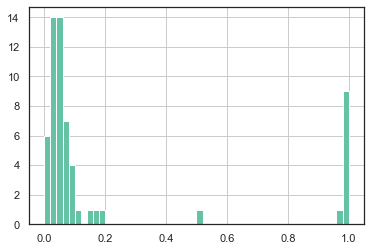

In [67]:
polab.reset_index().groupby('lab_id').positive_rate.mean().hist(bins=50)

In [68]:
top_5_labs = bdi[(bdi.test_for_corona_diagnosis==1)].lab_id.value_counts().index[:10]
top_5_labs

Int64Index([43, 16, 3, 21, 13, 4, 10, 15, 14, 12], dtype='int64')

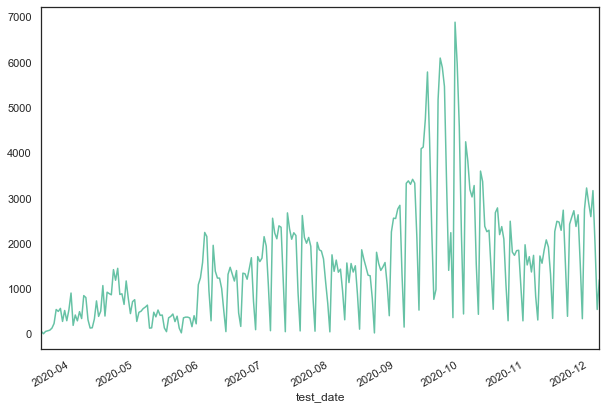

In [69]:
bdi[(bdi.lab_id==21)].groupby('test_date').size().plot(figsize=(10,7))

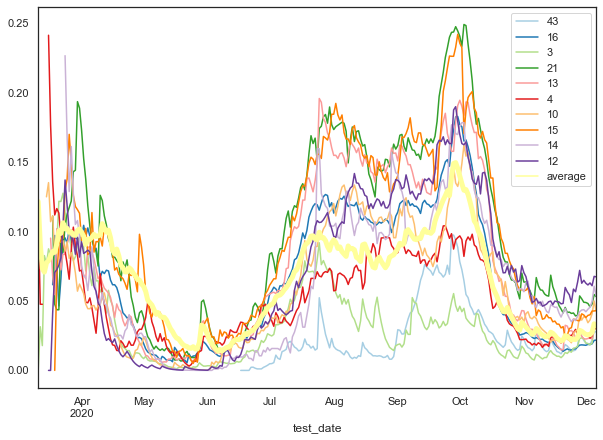

In [70]:
sns.set_palette(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928'])
forp = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1).ewm(span=7).mean()
ax = forp[forp<0.3].plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=([1.5]*10+[5])[i])


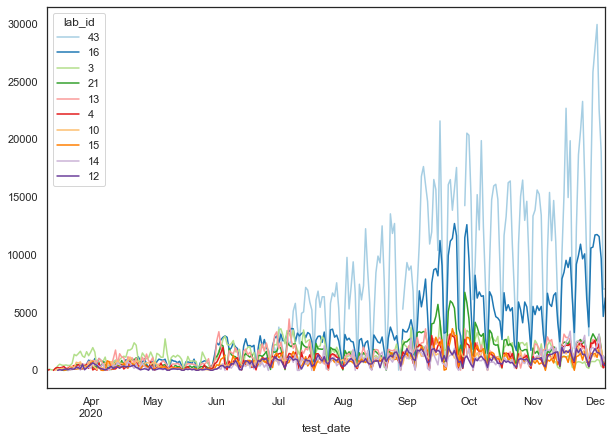

In [71]:
forp = polab.total_tests.unstack()[top_5_labs]
ax = forp.plot(figsize=(10,7))
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=([1.5]*10+[5])[i])


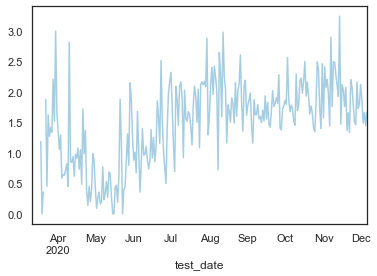

In [72]:
top_labs_pr = pd.concat([polab.positive_rate.unstack()[top_5_labs], pr.rename(columns={'positive_rate': 'average'}).average], axis=1)
top_labs_pr['ratio_21'] = top_labs_pr.loc[:, 21]/top_labs_pr.average
top_labs_pr.ratio_21.plot()

In [73]:
bdi[bdi.lab_id==21].shape[0]/bdi.shape[0]

0.062261525509599416

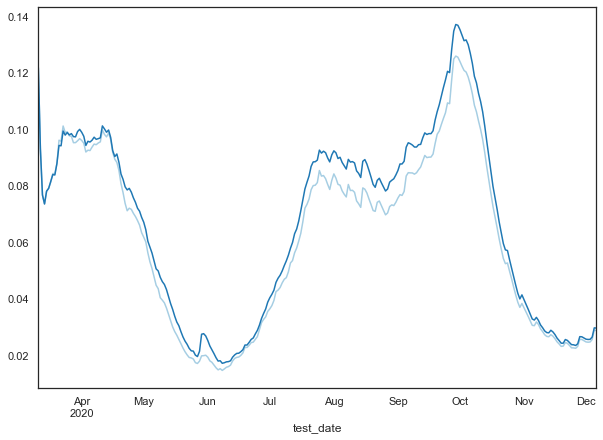

In [74]:
ax = (bdi[~(bdi.lab_id.isin([13,21]))].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo.ewm(7).mean().plot(figsize=(10,7))
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr.ewm(7).mean().plot(ax=ax, figsize=(10,7))

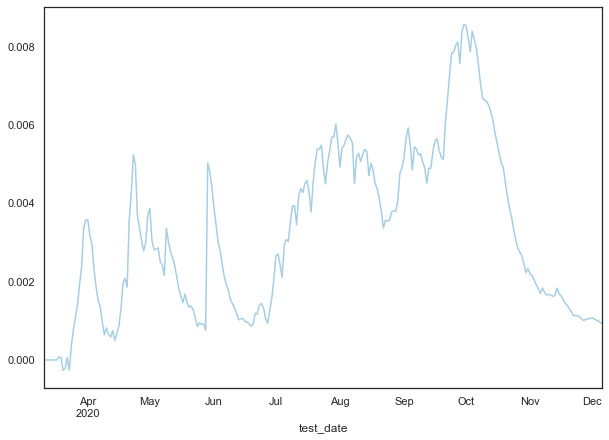

In [75]:
pd.concat([(bdi[bdi.lab_id!=21].groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr_wo = lambda x: x.positive/(x.negative+x.positive))).pr_wo,
(bdi.groupby(['test_date', 'corona_result']).size().unstack()
.assign(pr = lambda x: x.positive/(x.negative+x.positive))).pr], axis=1).assign(dif = lambda x: x.pr-x.pr_wo).dif.ewm(7).mean().plot(figsize=(10,7))

In [76]:
alt.Chart(polab[polab.total_tests>100].reset_index()).mark_point(size=2).encode(
    x='test_date',
    y='total_tests',
    color='positive_rate:Q',
    tooltip=['lab_id', 'test_date', 'total_tests', 'positive_rate']
).properties(width=600, height=450)

alt.Chart(...)

In [77]:
xx = (polab.reset_index().groupby('lab_id')[['positive', 'negative', 'total_tests']]
 .sum().sort_values(('total_tests'), ascending=False)
 .assign(positive_rate = lambda x: (x.positive / (x.negative+x.negative)).mul(100).round(1))
 .assign(positive_rq = lambda x: pd.qcut(x.positive_rate, 5))
)
xx

corona_result  positive   negative  total_tests  positive_rate     positive_rq
lab_id                                                                        
43              42651.0  1466060.0    1558521.0            1.5  (-0.001, 1.58]
16              65363.0   808486.0     879128.0            4.0    (2.56, 4.04]
3               11123.0   379005.0     392532.0            1.5  (-0.001, 1.58]
21              47531.0   327840.0     380501.0            7.2    (4.04, 8.88]
13              27198.0   299610.0     333715.0            4.5    (4.04, 8.88]
...                 ...        ...          ...            ...             ...
59                  9.0        0.0         29.0            inf     (8.88, inf]
87                  0.0        0.0         25.0            NaN             NaN
63                  0.0        0.0         21.0            NaN             NaN
72                  0.0        0.0         20.0            NaN             NaN
7                  18.0        0.0         18.0            inf     (8.88, inf]

[68 rows x 5 columns]

In [78]:
polab = polab.reset_index()
polab['total_pr'] = polab.lab_id.map(xx.positive_rate)
polab['total_prq'] = polab.lab_id.map(xx.positive_rq)
polab = polab.set_index(['test_date', 'lab_id'])
polab.head()

corona_result      Other  borderline  in_progress  negative  not_done  \
test_date  lab_id                                                       
2020-03-11 1         0.0         0.0          0.0       0.0       0.0   
           2         0.0         0.0          0.0      70.0       0.0   
           3         0.0         0.0          1.0      36.0       0.0   
           4         0.0         0.0          0.0      16.0       0.0   
           6         0.0         0.0         16.0       0.0       0.0   

corona_result      positive  positive_igum  uncertain  total_tests  \
test_date  lab_id                                                    
2020-03-11 1            2.0            0.0        0.0          2.0   
           2            0.0            0.0        0.0         70.0   
           3            0.0            0.0        1.0         38.0   
           4            2.0            0.0        0.0         18.0   
           6            0.0            0.0        0.0         16.0   

corona_result      positive_rate  total_pr       total_prq  
test_date  lab_id                                           
2020-03-11 1            1.000000      30.6     (8.88, inf]  
           2            0.000000       1.7    (1.58, 2.56]  
           3            0.000000       1.5  (-0.001, 1.58]  
           4            0.111111       3.0    (2.56, 4.04]  
           6                 NaN       1.2  (-0.001, 1.58]

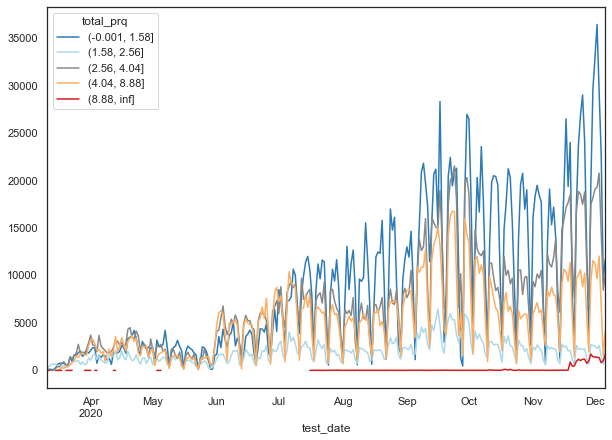

In [79]:
sns.set_palette(['#d7191c','#fdae61','#888888','#abd9e9','#2c7bb6'][::-1])
#sns.set_palette(['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000'])
sns.set_style('white')
prq = (polab.reset_index()
 .groupby(['test_date', 'total_prq']).total_tests.sum()
 .unstack()
)
prq.plot(figsize=(10,7))

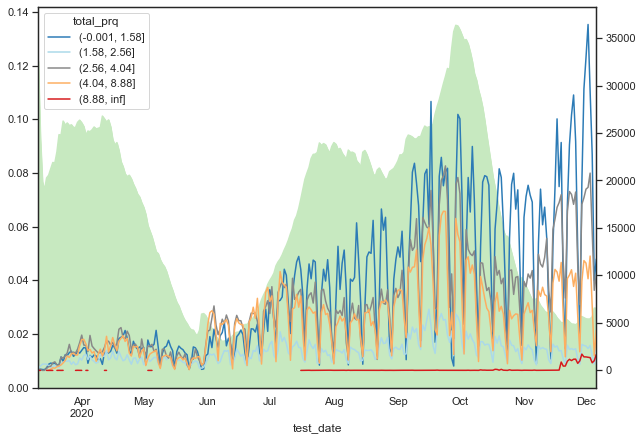

In [80]:
ax=(bdi.groupby(['test_date', 'corona_result']).size().unstack().fillna(0)
    .assign(pr = lambda x: x.positive/(x.negative+x.positive+x.borderline+x.uncertain))
   ).pr.ewm(7).mean().plot(color='#c7e9c0', kind='area', figsize=(10,7))
ax2=ax.twinx()
prq.plot(ax=ax2)

## Decseased 

In [81]:
last_dec = pd.read_csv(get_latest_file_glob('datagov_archive/corona_deceased_ver*.csv.gz'), 
                       encoding='1255', low_memory=False, compression='gzip')
last_dec['qc'] = pd.qcut(last_dec.Length_of_hospitalization, 11, duplicates='drop')
last_dec.qc.value_counts().sort_index()/len(last_dec)

(-0.001, 2.0]    0.185147
(2.0, 5.0]       0.117789
(5.0, 7.0]       0.096718
(7.0, 9.0]       0.080829
(9.0, 11.0]      0.075993
(11.0, 14.0]     0.084974
(14.0, 18.0]     0.093610
(18.0, 23.0]     0.087392
(23.0, 33.0]     0.082902
(33.0, 209.0]    0.089119
Name: qc, dtype: float64

In [82]:
sns.set_palette('Set2')


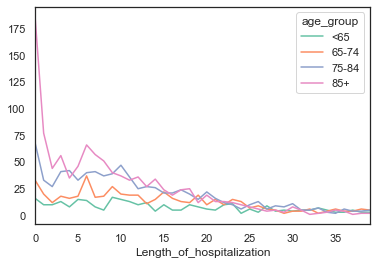

In [83]:
x = last_dec[last_dec['Length_of_hospitalization']<40].groupby(['Length_of_hospitalization', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.plot()

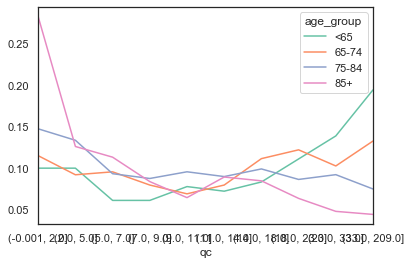

In [84]:
x = last_dec.groupby(['qc', 'age_group']).size().unstack()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=0), axis=1).plot()

In [85]:
(last_dec.Length_of_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

0.0    0.104663
1.0    0.048359
2.0    0.032124
3.0    0.044214
4.0    0.034888
5.0    0.038687
6.0    0.054231
7.0    0.042487
8.0    0.038342
9.0    0.042487
Name: Length_of_hospitalization, dtype: float64

In [86]:
(last_dec.Time_between_positive_and_hospitalization.value_counts().sort_index()/len(last_dec)).head(10)

-203.0    0.000345
-141.0    0.000345
-120.0    0.000345
-63.0     0.000345
-52.0     0.000345
-44.0     0.000345
-36.0     0.000345
-35.0     0.000691
-34.0     0.000345
-31.0     0.000691
Name: Time_between_positive_and_hospitalization, dtype: float64

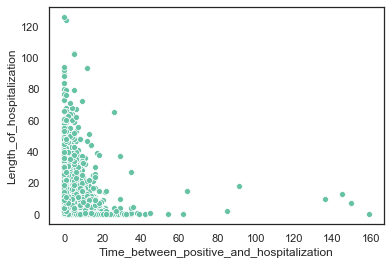

In [87]:
sns.scatterplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='Time_between_positive_and_hospitalization', y='Length_of_hospitalization')

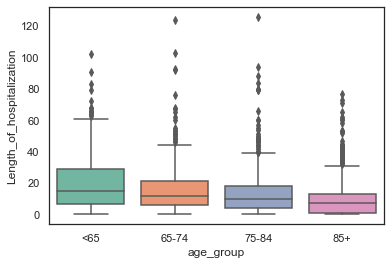

In [88]:
sns.boxplot(data=last_dec[last_dec.Time_between_positive_and_hospitalization>=0], x='age_group', y='Length_of_hospitalization', order=['<65', '65-74', '75-84', '85+'])

In [89]:
decs = []
for file in sorted(glob.glob('datagov_archive/corona_deceased_ver*.csv.gz'), key=os.path.getctime) :
    for enc in ['1255', 'utf-8-sig']:
        try:
            dec = pd.read_csv(file, 
                  encoding=enc, low_memory=False)
        except:
            continue
    dec['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    dec.time = dec.time
    dec['file'] = file
    decs.append(dec)

decs = pd.concat(decs).sort_values('time')
decs.head()

gender age_group  Ventilated  Time_between_positive_and_hospitalization  \
0      זכר       <65         1.0                                        2.0   
203   נקבה     75-84         1.0                                        0.0   
202   נקבה       85+         0.0                                       10.0   
201   נקבה       85+         0.0                                        2.0   
200    זכר       85+         1.0                                        0.0   

     Length_of_hospitalization  Time_between_positive_and_death  \
0                         20.0                             22.0   
203                       12.0                             12.0   
202                        1.0                             11.0   
201                       17.0                             19.0   
200                        9.0                              9.0   

                   time                                            file  
0   2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
203 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
202 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
201 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz  
200 2020-06-16 12:09:51  datagov_archive\corona_deceased_ver_001.csv.gz

In [90]:
decs.shape, (decs.drop_duplicates(subset=['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death']).shape)

((69398, 8), (2372, 8))

In [91]:
decs.columns

Index(['gender', 'age_group', 'Ventilated',
       'Time_between_positive_and_hospitalization',
       'Length_of_hospitalization', 'Time_between_positive_and_death', 'time',
       'file'],
      dtype='object')

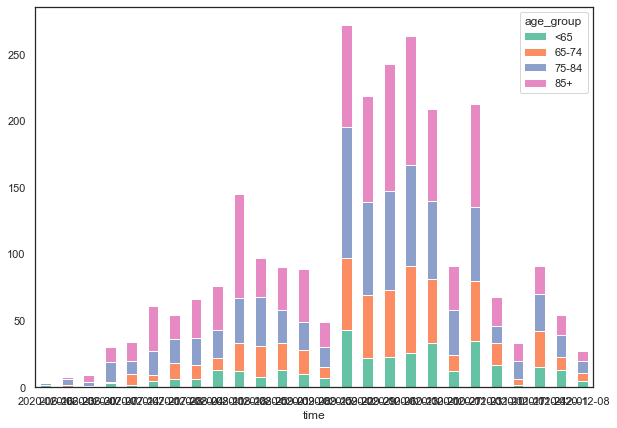

In [92]:
dec_dif = decs.groupby(['time', 'age_group']).size().unstack().diff()

dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

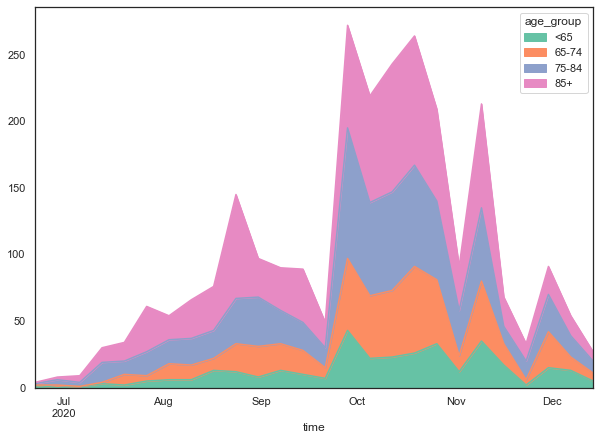

In [93]:
dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']].plot(kind='area', figsize=(10,7), rot=0)

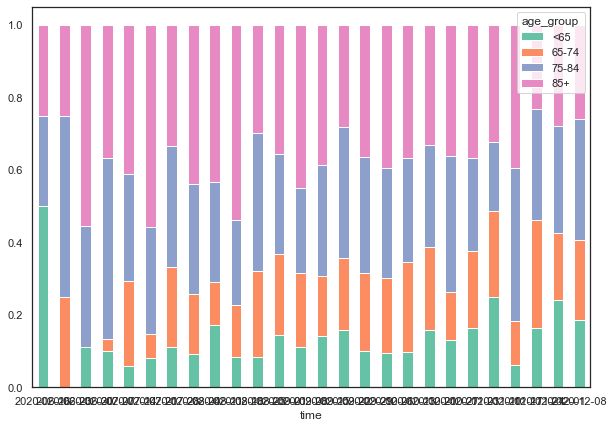

In [94]:
x = dec_dif.resample('7d', kind='period').sum()[['<65', '65-74', '75-84', '85+']]
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

In [95]:
dec_dif = decs.groupby(['time', 'Ventilated']).size().unstack().diff()

x = dec_dif.resample('7d', kind='period').sum()


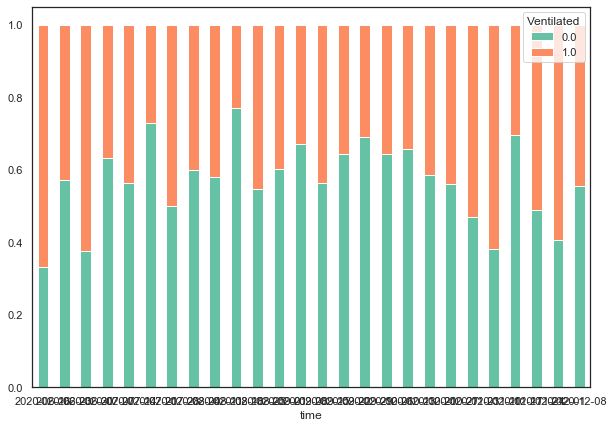

In [96]:
x.div(x.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(10,7), rot=0)

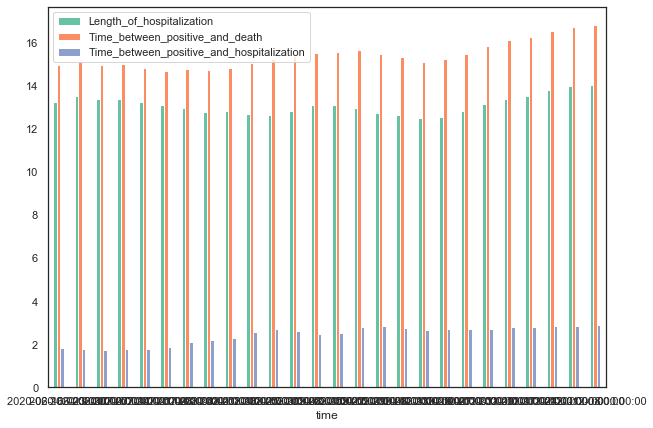

In [97]:
decs.resample('7d', on='time')[['Length_of_hospitalization', 'Time_between_positive_and_death', 'Time_between_positive_and_hospitalization']].mean().plot(kind='bar', figsize=(10,7), rot=0)


In [98]:
hos.head().T

0                    1  \
date                        2020-03-11 00:00:00  2020-03-12 00:00:00   
מאושפזים                                     79                  102   
אחוז נשים מאושפזות                         36.7                 40.2   
גיל ממוצע מאושפזים                           48                   50   
סטיית תקן גיל מאושפזים                       18                 18.1   
resp                                         15                   15   
אחוז נשים מונשמות                            20                   20   
גיל ממוצע מונשמים                            64                   64   
סטיית תקן גיל מונשמים                      15.4                 15.4   
חולים קל                                     72                   95   
אחוז נשים חולות קל                         37.5                 41.1   
גיל ממוצע חולים קל                           47                   49   
סטיית תקן גיל חולים קל                     17.4                 17.8   
medium                                       15                   15   
אחוז נשים חולות בינוני                      <15                  <15   
גיל ממוצע חולים בינוני                      <15                  <15   
סטיית תקן גיל חולים בינוני                  <15                  <15   
critical                                     15                   15   
אחוז נשים חולות קשה                        33.3                 33.3   
גיל ממוצע חולים קשה                          67                   67   
סטיית תקן גיל חולים קשה                    16.2                 16.2   
חולים קשה מצטבר                             <15                  <15   

                                              2                    3  \
date                        2020-03-13 00:00:00  2020-03-14 00:00:00   
מאושפזים                                    120                  158   
אחוז נשים מאושפזות                         39.2                 41.1   
גיל ממוצע מאושפזים                           50                   48   
סטיית תקן גיל מאושפזים                     18.2                 18.4   
resp                                         15                   15   
אחוז נשים מונשמות                            20                    0   
גיל ממוצע מונשמים                            64                   70   
סטיית תקן גיל מונשמים                      15.4                  6.8   
חולים קל                                    109                  148   
אחוז נשים חולות קל                         39.4                 41.9   
גיל ממוצע חולים קל                           48                   46   
סטיית תקן גיל חולים קל                     17.5                 17.5   
medium                                       15                   15   
אחוז נשים חולות בינוני                       40                   40   
גיל ממוצע חולים בינוני                       68                   68   
סטיית תקן גיל חולים בינוני                 17.1                 17.1   
critical                                     15                   15   
אחוז נשים חולות קשה                        33.3                   20   
גיל ממוצע חולים קשה                          67                   77   
סטיית תקן גיל חולים קשה                    16.2                   10   
חולים קשה מצטבר                             <15                  <15   

                                              4  
date                        2020-03-15 00:00:00  
מאושפזים                                    197  
אחוז נשים מאושפזות                         44.2  
גיל ממוצע מאושפזים                           47  
סטיית תקן גיל מאושפזים                     18.7  
resp                                         15  
אחוז נשים מונשמות                            20  
גיל ממוצע מונשמים                            74  
סטיית תקן גיל מונשמים                       7.3  
חולים קל                                    182  
אחוז נשים חולות קל                         44.5  
גיל ממוצע חולים קל                           45  
סטיית תקן גיל חולים קל                     17.5  
medium                          

In [99]:
rec.head()

days_between_pos_and_neg total_tests_count age_group gender  \
0                        19                 9     40-49    זכר   
1                        22                 9     30-39    זכר   
2                        26                 9     30-39    זכר   
3                        28                 9     30-39   נקבה   
4                        23                 9     20-29   נקבה   

          test_indication  
0                  Abroad  
1  Contact with confirmed  
2  Contact with confirmed  
3                  Abroad  
4  Contact with confirmed

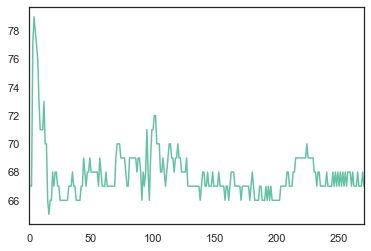

In [100]:
hos['גיל ממוצע חולים קשה'].plot()

## Recovered

In [101]:
pd.read_csv('datagov_archive/corona_recovered_ver_004.csv.gz', encoding='1255')

days_between_pos_and_neg total_tests_count age_group gender  \
0                          8.0                 9     40-49   נקבה   
1                         19.0                 9     30-39    זכר   
2                         33.0                 9       60+    זכר   
3                         24.0                 9     30-39    זכר   
4                         20.0                 9     40-49    זכר   
...                        ...               ...       ...    ...   
6408                       NaN               NaN       60+    זכר   
6409                       NaN               NaN       60+   נקבה   
6410                       NaN               NaN       60+   נקבה   
6411                       NaN               NaN       60+    זכר   
6412                       NaN               NaN       60+    זכר   

             test_indication  
0     Contact with confirmed  
1     Contact with confirmed  
2                     Abroad  
3     Contact with confirmed  
4                     Abroad  
...                      ...  
6408                   Other  
6409  Contact with confirmed  
6410  Contact with confirmed  
6411                  Abroad  
6412                  Abroad  

[6413 rows x 5 columns]

In [102]:
recs = []
for file in sorted(glob.glob('datagov_archive/corona_recovered*.csv.gz'), key=os.path.getctime) :
    try:
        r = pd.read_csv(file, 
                  encoding='1255', low_memory=False)
    except:
        r = pd.read_csv(file, 
                  encoding='utf-8', low_memory=False)
    print(file, pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False))
    r['time'] = pd.to_datetime(round(os.path.getctime(file)),unit='s', exact=False)
    r['file'] = file
    recs.append(r)

recs = pd.concat(recs)
recs['ver'] = recs.file.str.extract('ver_0+([1-9][0-9]*)').astype(int)
recs = recs.sort_values('ver')
recs.head()

datagov_archive\corona_recovered_ver_0010.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_0012.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_004.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_005.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_006.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_007.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_008.csv.gz 2020-05-30 14:05:58
datagov_archive\corona_recovered_ver_0016.csv.gz 2020-06-10 10:31:01
datagov_archive\corona_recovered_ver_0017.csv.gz 2020-06-11 13:45:44
datagov_archive\corona_recovered_ver_0018.csv.gz 2020-06-16 12:09:51
datagov_archive\corona_recovered_ver_0020.csv.gz 2020-06-19 12:31:14
datagov_archive\corona_recovered_ver_0021.csv.gz 2020-06-22 19:27:14
datagov_archive\corona_recovered_ver_0023.csv.gz 2020-06-28 07:56:06
datagov_archive\corona_recovered_ver_0024.csv.gz 2020-06-29 09:30:26
datagov_archive\corona_recovered_ver_00

days_between_pos_and_neg total_tests_count age_group gender  \
4923                      12.0                 3     30-39   נקבה   
4281                      15.0                 3     40-49   נקבה   
4280                       4.0                 3     20-29   נקבה   
4279                      13.0                 3     50-59    זכר   
4278                       7.0                 3     30-39   נקבה   

     test_indication                time  \
4923           Other 2020-05-30 14:05:58   
4281           Other 2020-05-30 14:05:58   
4280           Other 2020-05-30 14:05:58   
4279           Other 2020-05-30 14:05:58   
4278          Abroad 2020-05-30 14:05:58   

                                                 file  ver  
4923  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4281  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4280  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4279  datagov_archive\corona_recovered_ver_004.csv.gz    4  
4278  datagov_archive\corona_recovered_ver_004.csv.gz    4

In [103]:
recs.ver.value_counts()

35    23651
34    21193
33    19878
32    18529
31    17913
26    16922
25    16427
24    16158
23    15883
21    15650
20    15485
18    15383
17    15254
16    15139
12    13863
10    12841
8     11251
7     10828
6      9419
5      8492
4      6413
Name: ver, dtype: int64

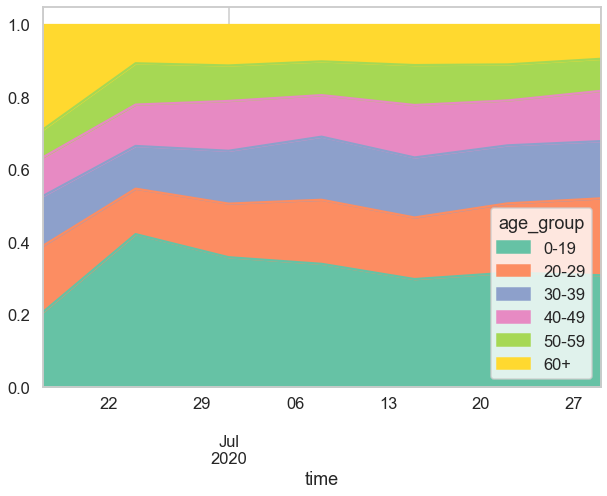

In [104]:
sns.set_style('whitegrid')
sns.set_context('talk')

rec_dif = recs[recs.ver>=17].groupby(['time', 'age_group']).size().unstack().diff()
rec_dif
x=rec_dif.resample('7d', kind='period').sum()

x.div(x.sum(axis=1),axis=0).plot(kind='area', figsize=(10,7), rot=0)

## Age & Gender

In [105]:
import gzip

def get_sep(path, encoding='utf-8'):
    if '.gz' in path:
        my_open=gzip.open
    else:
        my_open=open
    with my_open(path, 'rt', encoding=encoding) as f:
        first_line = f.readline()
    if '\t' in first_line:
        sep='\t'
    else:
        sep=','
    return sep

def get_latest_df(prefix, data_folder='datagov_archive', suffix='*.csv.gz'):
    pat = os.path.join(data_folder, prefix+suffix)
    latest = get_latest_file_glob(pat)
    
    try:
        sep = get_sep(latest, '1255')
        df = pd.read_csv(latest, 
                  encoding='1255', low_memory=False, sep=sep)
    except:
        sep = get_sep(latest, 'utf-8-sig')
        df = pd.read_csv(latest, 
                  encoding='utf-8-sig', low_memory=False, sep=sep)
    return df
                
ag = get_latest_df('corona_age_and_gender')
ag.head()
    

first_week_day last_week_day age_group   gender weekly_tests_num  \
0     2020-03-15    2020-03-21      0-19      זכר           1083.0   
1     2020-03-15    2020-03-21      0-19     נקבה            894.0   
2     2020-03-15    2020-03-21      0-19  לא ידוע             31.0   
3     2020-03-15    2020-03-21     20-24     נקבה            620.0   
4     2020-03-15    2020-03-21     20-24      זכר            695.0   

  weekly_newly_tested weekly_cases weekly_deceased  
0              1032.0         36.0             0.0  
1               857.0         39.0             0.0  
2                31.0          0.0             0.0  
3               601.0         34.0             0.0  
4               650.0        105.0             0.0

In [106]:
ag.weekly_deceased.value_counts()

0.0     1276
<15      383
27.0       4
15.0       4
20.0       4
22.0       3
26.0       3
18.0       3
33.0       2
19.0       2
16.0       2
17.0       2
34.0       2
23.0       2
51.0       1
29.0       1
47.0       1
46.0       1
63.0       1
70.0       1
25.0       1
76.0       1
31.0       1
74.0       1
52.0       1
39.0       1
55.0       1
66.0       1
21.0       1
60.0       1
32.0       1
35.0       1
Name: weekly_deceased, dtype: int64

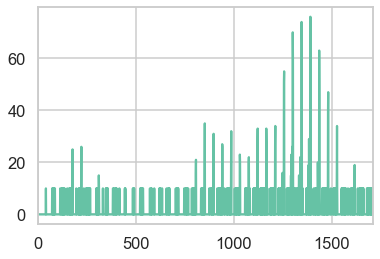

In [107]:
ag.weekly_deceased.replace('<15','10').astype(float).astype(int).plot()

## Dashboard Data

In [122]:
dash_folder = 'dashboard_data'
city_file_name = 'contagionDataPerCityPublic.csv'

In [123]:
city_df = pd.DataFrame()
for folder in os.scandir(dash_folder):
    if os.path.isdir(folder):
        for tfolder in os.scandir(folder):
            city_path = os.path.join(tfolder, city_file_name)
            if os.path.isdir(tfolder) and os.path.exists(city_path):
                city_df = city_df.append(pd.read_csv(city_path), sort=False)
                
city_df['date'] = pd.to_datetime(city_df.date)
city_df.head()

city sickCount actualSick verifiedLast7Days  testLast7Days  \
0        ירושלים     16214       3748              1266          13868   
1        בני ברק      9144       1252               482           3043   
2  מודיעין עילית      3122       1085               475           2004   
3            רהט       780        240               118            792   
4       כפר קאסם       455        185               109            501   

   patientDiffPopulationForTenThousands                             status  \
0                                    40  נדרשים הסברה, בדיקות ואכיפת בידוד   
1                                    62  נדרשים הסברה, בדיקות ואכיפת בידוד   
2                                   141  נדרשים הסברה, בדיקות ואכיפת בידוד   
3                                    36  נדרשים הסברה, בדיקות ואכיפת בידוד   
4                                    77  נדרשים הסברה, בדיקות ואכיפת בידוד   

                 lastUpdate                             date  
0  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
1  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
2  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
3  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00  
4  2020-08-19T07:38:12.840Z 2020-08-19 07:38:12.840000+00:00

In [124]:
city_df.dtypes

city                                                 object
sickCount                                            object
actualSick                                           object
verifiedLast7Days                                    object
testLast7Days                                         int64
patientDiffPopulationForTenThousands                  int64
status                                               object
lastUpdate                                           object
date                                    datetime64[ns, UTC]
dtype: object

In [125]:
city_tests = (city_df
              .groupby([pd.Grouper(key='date', freq='1d'), 'city'])['testLast7Days', 'verifiedLast7Days'].max()
              .assign(positive_rate = lambda x: x.verifiedLast7Days.str.strip().replace('<15', '8').replace('1-5', '3').replace('6-10', '8').replace('11-14', '13').astype(int) / x.testLast7Days)
              .reset_index())
city_tests.head()

date                city  testLast7Days  \
0 2020-08-19 00:00:00+00:00  אבו ג'ווייעד (שבט)             12   
1 2020-08-19 00:00:00+00:00             אבו גוש            256   
2 2020-08-19 00:00:00+00:00            אבו סנאן            399   
3 2020-08-19 00:00:00+00:00   אבו קורינאת (שבט)             13   
4 2020-08-19 00:00:00+00:00   אבו רובייעה (שבט)             20   

  verifiedLast7Days  positive_rate  
0                 0       0.000000  
1                24       0.093750  
2                18       0.045113  
3                 0       0.000000  
4                 0       0.000000

In [126]:
#top_cities = city_tests.groupby('city').testLast7Days.mean().sort_values(ascending=False)[:20].index
from datetime import date, timedelta
yesterday = city_tests.date.max() - timedelta(days=1)
top_cities = city_tests[city_tests.date==yesterday].sort_values(by='testLast7Days', ascending=False).head(20).city

In [127]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).mark_trail().encode(
    x='date',
    y='testLast7Days',
    size=alt.Size('positive_rate:Q', bin={'steps':[0.02,0.05,0.1]}),
    color='city',
    tooltip=['date', 'city', 'testLast7Days', 'positive_rate']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [128]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).transform_joinaggregate(
     groupby = ['date'], TotalTests='sum(testLast7Days)',
).transform_calculate(
    PercentTests="datum.testLast7Days / datum.TotalTests"
).mark_area().encode(
    x='date',
    y='PercentTests:Q',
    color='city',
    #size='mean(positive_rate)',
    tooltip=['date', 'city', 'PercentTests:Q']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [129]:
alt.Chart(city_tests[city_tests.city.isin(top_cities)]).mark_trail().encode(
    x='date',
    y='positive_rate',
    size=alt.Size('testLast7Days', bin={'steps':[1000,2000,5000,10000]}),
    color='city',
    tooltip=['date', 'city', 'testLast7Days', 'positive_rate']
).properties(width=600, height=450).interactive()

alt.Chart(...)

In [130]:
ct_change = (city_tests[city_tests.date.isin(['2020-08-31',yesterday.strftime('%Y-%m-%d') ])]
 .assign(date = lambda x: x.date.dt.strftime('%Y-%m-%d'))            
 .pivot(index='city', columns='date')[['testLast7Days', 'positive_rate']]
 .assign(test_ratio=lambda x: (x.iloc[:, 1]/x.iloc[:,0]).round(2))
 .assign(pr_ratio=lambda x: (x.iloc[:, 3]/x.iloc[:,2]).round(2))
 .assign(positive_rate = lambda x: x.positive_rate.round(2))
 .sort_values(by='test_ratio', ascending=False)
 
 )
ct_change[ct_change[('testLast7Days', yesterday.strftime('%Y-%m-%d'))]>=300].head(30)#.loc[list(top_cities), :]


testLast7Days            positive_rate            test_ratio  \
date                2020-08-31 2020-12-08    2020-08-31 2020-12-08              
city                                                                            
מסעדה                       18        758          0.17       0.06      42.11   
קדומים                      52       1163          0.06       0.01      22.37   
אילת                       520      11196          0.05       0.00      21.53   
ג'ש (גוש חלב)               35        585          0.09       0.01      16.71   
גבעת שמואל                 302       4611          0.07       0.00      15.27   
מג'דל שמס                  103       1564          0.08       0.10      15.18   
כפר מצר                     30        308          0.10       0.09      10.27   
צור יצחק                    72        700          0.04       0.02       9.72   
מצפה רמון                   39        367          0.08       0.01       9.41   
עיילבון                     94        830          0.09       0.02       8.83   
ערד                        346       2823          0.02       0.01       8.16   
אלון שבות                   54        438          0.00       0.03       8.11   
חשמונאים                    49        369          0.06       0.01       7.53   
יד בנימין                   56        411          0.14       0.02       7.34   
טלמון                       44        301          0.00       0.00       6.84   
יפיע                       227       1526          0.11       0.09       6.72   
עין נקובא                   63        392          0.05       0.06       6.22   
אריאל                      206       1269          0.01       0.02       6.16   
כפר ורדים                   71        434          0.04       0.02       6.11   
בועיינה-נוג'ידאת           151        892          0.14       0.04       5.91   
שעב                        158        919          0.05       0.06       5.82   
בית דגן                     65        369          0.05       0.01       5.68   
כסיפה                      106        597          0.12       0.04       5.63   
רמת ישי                     88        490          0.03       0.01       5.57   
אפרת                       174        957          0.07       0.00       5.50   
מעלות-תרשיחא               367       1982          0.04       0.03       5.40   
כפר מנדא                   172        923          0.17       0.10       5.37   
הר אדר                      64        337          0.05       0.01       5.27   
צור הדסה                   157        808          0.02       0.02       5.15   
אכסאל                      231       1172          0.03       0.05       5.07   

                 pr_ratio  
date                       
city                       
מסעדה                0.34  
קדומים               0.19  
אילת                 0.04  
ג'ש (גוש חלב)        0.16  
גבעת שמואל           0.02  
מג'דל שמס            1.27  
כפר מצר              0.91  
צור יצחק             0.45  
מצפה רמון            0.11  
עיילבון              0.28  
ערד                  0.23  
אלון שבות             inf  
חשמונאים             0.13  
יד בנימין            0.14  
טלמון                 NaN  
יפיע                 0.77  
עין נקובא            1.29  
אריאל                1.30  
כפר ורדים            0.44  
בועיינה-נוג'ידאת     0.31  
שעב                  1.12  
בית דגן              0.18  
כסיפה                0.29  
רמת ישי              0.18  
אפרת                 0.04  
מעלות-תרשיחא         0.84  
כפר מנדא             0.57  
הר אדר               0.19  
צור הדסה             0.84  
אכסאל                1.53

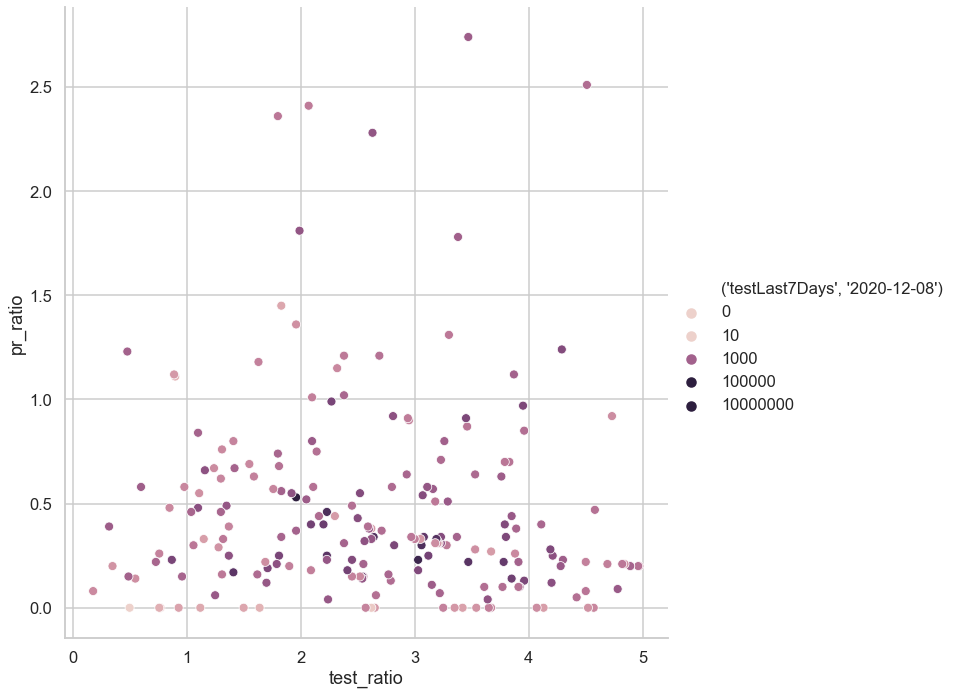

In [131]:
from matplotlib.colors import LogNorm

sns.relplot(data=ct_change[(ct_change.test_ratio<5) & (ct_change.pr_ratio<4)], x='test_ratio', y='pr_ratio', 
            hue=('testLast7Days', yesterday.strftime('%Y-%m-%d')), hue_norm=LogNorm(),
            height=10)

In [132]:
tr_file_name = 'testResultsPerDate.csv'

In [133]:
tr_df = pd.DataFrame()
for folder in os.scandir(dash_folder):
    if os.path.isdir(folder):
        for tfolder in os.scandir(folder):
            tr_path = os.path.join(tfolder, tr_file_name)
            if os.path.isdir(tfolder) and os.path.exists(tr_path):
                tr_df = tr_df.append(pd.read_csv(tr_path), sort=False)
                
tr_df['date'] = pd.to_datetime(tr_df.date)
tr_df.tail()

date  amount  amountVirusDiagnosis  positiveAmount  \
312 2020-12-05 00:00:00+00:00   25868                 25363             998   
313 2020-12-06 00:00:00+00:00   42915                 42053            1360   
314 2020-12-07 00:00:00+00:00   67610                 66038            1850   
315 2020-12-08 00:00:00+00:00   69788                 68473            1720   
316 2020-12-09 00:00:00+00:00    5948                  5841             152   

                   lastUpdate  amountMagen  
312  2020-12-09T07:49:39.820Z       1602.0  
313  2020-12-09T07:49:39.820Z       1843.0  
314  2020-12-09T07:49:39.820Z       9314.0  
315  2020-12-09T07:49:39.820Z      10733.0  
316  2020-12-09T07:49:39.820Z        602.0

In [134]:
tr_df.dtypes

date                    datetime64[ns, UTC]
amount                                int64
amountVirusDiagnosis                  int64
positiveAmount                        int64
lastUpdate                           object
amountMagen                         float64
dtype: object

In [136]:
tr = (tr_df.sort_values('lastUpdate', ascending=False)
              .groupby(['date']).head(1)
              .sort_values('date')
     .assign(positive_rate = lambda x: x.positiveAmount/x.amountVirusDiagnosis))
tr.tail(20)

date  amount  amountVirusDiagnosis  positiveAmount  \
297 2020-11-20 00:00:00+00:00   44099                 43224             773   
298 2020-11-21 00:00:00+00:00   15893                 15605             422   
299 2020-11-22 00:00:00+00:00   35011                 34314             764   
300 2020-11-23 00:00:00+00:00   53670                 52500             959   
301 2020-11-24 00:00:00+00:00   60000                 58727             857   
302 2020-11-25 00:00:00+00:00   61037                 59641            1079   
303 2020-11-26 00:00:00+00:00   54561                 53375            1085   
304 2020-11-27 00:00:00+00:00   48852                 47971            1032   
305 2020-11-28 00:00:00+00:00   17527                 17181             581   
306 2020-11-29 00:00:00+00:00   40456                 39517            1024   
307 2020-11-30 00:00:00+00:00   58845                 57529            1258   
308 2020-12-01 00:00:00+00:00   65289                 63975            1199   
309 2020-12-02 00:00:00+00:00   72793                 71248            1587   
310 2020-12-03 00:00:00+00:00   65454                 64144            1451   
311 2020-12-04 00:00:00+00:00   61634                 60399            1516   
312 2020-12-05 00:00:00+00:00   25868                 25363             998   
313 2020-12-06 00:00:00+00:00   42915                 42053            1360   
314 2020-12-07 00:00:00+00:00   67610                 66038            1850   
315 2020-12-08 00:00:00+00:00   69788                 68473            1720   
316 2020-12-09 00:00:00+00:00    5948                  5841             152   

                   lastUpdate  amountMagen  positive_rate  
297  2020-12-09T07:49:39.820Z       5598.0       0.017884  
298  2020-12-09T07:49:39.820Z        296.0       0.027043  
299  2020-12-09T07:49:39.820Z       3108.0       0.022265  
300  2020-12-09T07:49:39.820Z      12076.0       0.018267  
301  2020-12-09T07:49:39.820Z      14636.0       0.014593  
302  2020-12-09T07:49:39.820Z      12893.0       0.018092  
303  2020-12-09T07:49:39.820Z       6395.0       0.020328  
304  2020-12-09T07:49:39.820Z       5989.0       0.021513  
305  2020-12-09T07:49:39.820Z       3148.0       0.033816  
306  2020-12-09T07:49:39.820Z       3200.0       0.025913  
307  2020-12-09T07:49:39.820Z      10458.0       0.021867  
308  2020-12-09T07:49:39.820Z      15380.0       0.018742  
309  2020-12-09T07:49:39.820Z      13544.0       0.022274  
310  2020-12-09T07:49:39.820Z      11444.0       0.022621  
311  2020-12-09T07:49:39.820Z       8325.0       0.025100  
312  2020-12-09T07:49:39.820Z       1602.0       0.039349  
313  2020-12-09T07:49:39.820Z       1843.0       0.032340  
314  2020-12-09T07:49:39.820Z       9314.0       0.028014  
315  2020-12-09T07:49:39.820Z      10733.0       0.025119  
316  2020-12-09T07:49:39.820Z        602.0       0.026023